In [ ]:
!pip install memory_profiler


In [ ]:
!pip install imbalanced-learn


In [ ]:
# Loading neccesary libraries:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from memory_profiler import memory_usage
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
import re





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/HateDetector/labeled_data.csv')
#Print that data imported successfully
print("Data imported successfully")
data.drop('Unnamed: 0', axis=1, inplace=True)
data.shape



Data imported successfully


(24783, 6)

#Visualization

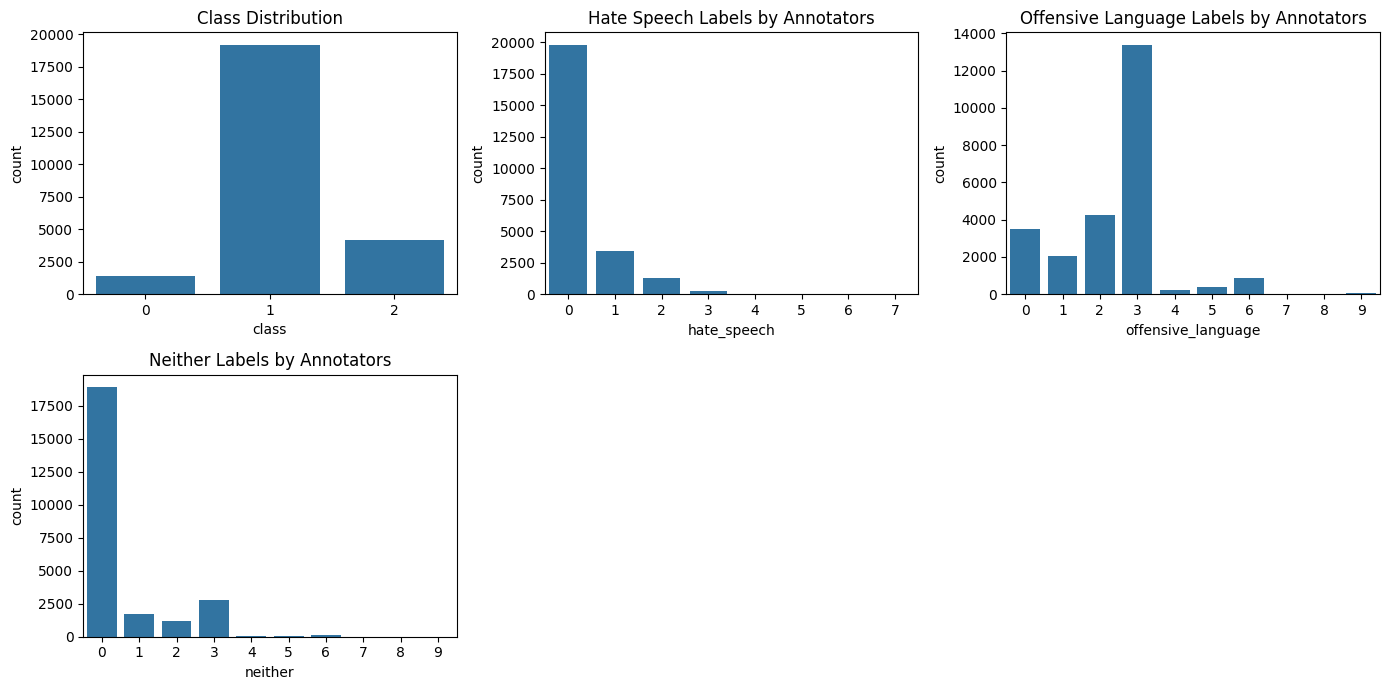

In [ ]:
# Setting up the matplotlib figure
plt.figure(figsize=(14, 7))

#  distribution of classes
plt.subplot(2, 3, 1)
sns.countplot(data=data,x='class' )
plt.title('Class Distribution')

#  hate speech
plt.subplot(2, 3, 2)
sns.countplot(x='hate_speech', data=data)
plt.title('Hate Speech Labels by Annotators')

#  offensive language
plt.subplot(2, 3, 3)
sns.countplot(x='offensive_language', data=data)
plt.title('Offensive Language Labels by Annotators')

#  neither
plt.subplot(2, 3, 4)
sns.countplot(x='neither', data=data)
plt.title('Neither Labels by Annotators')


# Adjust the layout
plt.tight_layout()
plt.show()


#Reflection
The plot shows us the number or frquency of tweets classified as hate,offensive,neither by annotators.
As we can clearly observe that there is an imbalance in our dataset.The number of tweets classfied as Offensive is way more than hate and neither.Therefore we need to address this imbalance while training the model.

#Pre-processing of Data

In [ ]:

nltk.download('stopwords')
nltk.download('punkt')


# Update the function to include tokenization, removal of stop words, and stemming
def clean_tokenize_stem(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs, handles, and the hashtag symbol
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize by splitting on whitespace
    tokens = word_tokenize(text)
    # Load stop words from NLTK
    stop_words = set(stopwords.words('english'))
    # Initialize the Porter Stemmer
    porter = PorterStemmer()
    # Filter out stop words and apply stemming
    filtered_stemmed_tokens = [porter.stem(word) for word in tokens if word not in stop_words]
    return filtered_stemmed_tokens

# Apply the updated function to each tweet
data['tokens'] = data['tweet'].apply(clean_tokenize_stem)

# Flatten all the token lists into a single list and count the occurrences
all_words = [word for tokens in data['tokens'] for word in tokens]
word_counts = Counter(all_words)

# Assuming you want to remove extremely common or Twitter-specific terms programmatically this time
additional_stop_words = {'rt'}
filtered_words = {word: count for word, count in word_counts.items() if word not in additional_stop_words}

# Display the most common words that are not in the additional stop words list
common_words = Counter(filtered_words).most_common(20)
common_words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[('bitch', 11336),
 ('hoe', 4283),
 ('like', 2855),
 ('fuck', 2251),
 ('pussi', 2217),
 ('im', 2090),
 ('nigga', 1991),
 ('dont', 1784),
 ('get', 1777),
 ('got', 1610),
 ('ass', 1587),
 ('shit', 1292),
 ('u', 1282),
 ('aint', 1169),
 ('trash', 1153),
 ('lol', 1068),
 ('go', 902),
 ('know', 880),
 ('amp', 845),
 ('love', 771)]

As you can see we have dropped the unamed column.
Also we can also visualize how the tweet is tokenized.
Notice we need to further do pre-processing so as to extract only the useful tokens from the tweet.

In [ ]:


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['class'], test_size=0.2, random_state=42)

# Define the features (words) that we will calculate TF-IDF scores for
features = [
    'bitch', 'pussi', 'ass', 'shit', 'fuck', 'nigga',
    'dick', 'cunt', 'fag', 'hoes','hoe','bitches','trash'
]

# Initialize the TF-IDF Vectorizer with predefined vocabulary
tfidf_vectorizer = TfidfVectorizer(vocabulary=features)

# Fit the vectorizer on the training data
tfidf_vectorizer.fit(X_train)

# Transform both the training and test data
X_train = tfidf_vectorizer.transform(X_train)
X_test= tfidf_vectorizer.transform(X_test)

# Convert the TF-IDF matrices to DataFrames to visualize them better
tfidf_train_df = pd.DataFrame(X_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_test_df = pd.DataFrame(X_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_train_df.head()


,bitch,pussi,ass,shit,fuck,nigga,dick,cunt,fag,hoes,hoe,bitches,trash
0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.466636,0.0,0.000000,0.0,0.0,0.88445,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.489359,0.0,0.872082,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Model-1:Decision Tree

#Without smote

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import time
from memory_profiler import memory_usage

# Initialize Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {'max_depth': [10, 20, 30, 40, 50, None]}


# Initialize GridSearchCV
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='accuracy', verbose=1)

# Start timing
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# End timing
end_time = time.time()

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)
memory = memory_usage(max_usage=True)


# Output the results
training_time = end_time - start_time
best_params = grid_search.best_params_

print(f"Classification Report:\n{report}")
print(f"Training Time: {training_time} seconds")
print(f"Best Parameters: {best_params}")
print(f"Memory used: {memory} MiB")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.01      0.02       290
           1       0.80      0.99      0.88      3832
           2       0.71      0.18      0.29       835

    accuracy                           0.80      4957
   macro avg       0.59      0.39      0.40      4957
weighted avg       0.75      0.80      0.73      4957

Training Time: 1.912222146987915 seconds
Best Parameters: {'max_depth': 10}
Memory used: 298.015625 MiB


In [ ]:
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Define the parameter grid for Decision Tree
param_grid_dt = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Define multiple scoring metrics
scoring_metrics = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Create a Decision Tree pipeline with SMOTE
pipeline_dt = ImPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Setup GridSearchCV for the Decision Tree pipeline with multiple scoring metrics
grid_search_dt = GridSearchCV(
    pipeline_dt,
    param_grid_dt,
    scoring=scoring_metrics,
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=3
)

# Fit the grid search to the data
grid_search_dt.fit(X_train, y_train)

# Extract the best parameters
best_params_dt = grid_search_dt.best_params_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:

# Initialize Decision Tree with the best parameters
dt_best = DecisionTreeClassifier(
    criterion=best_params_dt['classifier__criterion'],
    max_depth=best_params_dt['classifier__max_depth'],
    min_samples_split=best_params_dt['classifier__min_samples_split'],
    min_samples_leaf=best_params_dt['classifier__min_samples_leaf'],
    random_state=42
)

# Update pipeline with the best parameters
pipeline_dt_best = ImPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', dt_best)
])

# Time the fitting and prediction process
start_time_dt = time.time()
pipeline_dt_best.fit(X_train, y_train)
predictions_dt = pipeline_dt_best.predict(X_test)
end_time_dt = time.time()
time_taken_dt = end_time_dt - start_time_dt

# Calculate precision, recall, and F1 score
accuracy_dt = accuracy_score(y_test, predictions_dt)
precision_dt = precision_score(y_test, predictions_dt, average='weighted')
recall_dt = recall_score(y_test, predictions_dt, average='weighted')
f1_dt = f1_score(y_test, predictions_dt, average='weighted')
memory = memory_usage(max_usage=True)

# Compile results for the Decision Tree classifier
results_dt = {
    'time_taken': time_taken_dt,
    'precision': precision_dt,
    'recall': recall_dt,
    'f1_score': f1_dt,
    'accuracy': accuracy_dt
}
print(f"Memory used: {memory} MiB")
print(results_dt)


Memory used: 469.796875 MiB
{'time_taken': 0.10577988624572754, 'precision': 0.8397891513627708, 'recall': 0.7425862416784346, 'f1_score': 0.7637440561214637, 'accuracy': 0.7425862416784346}


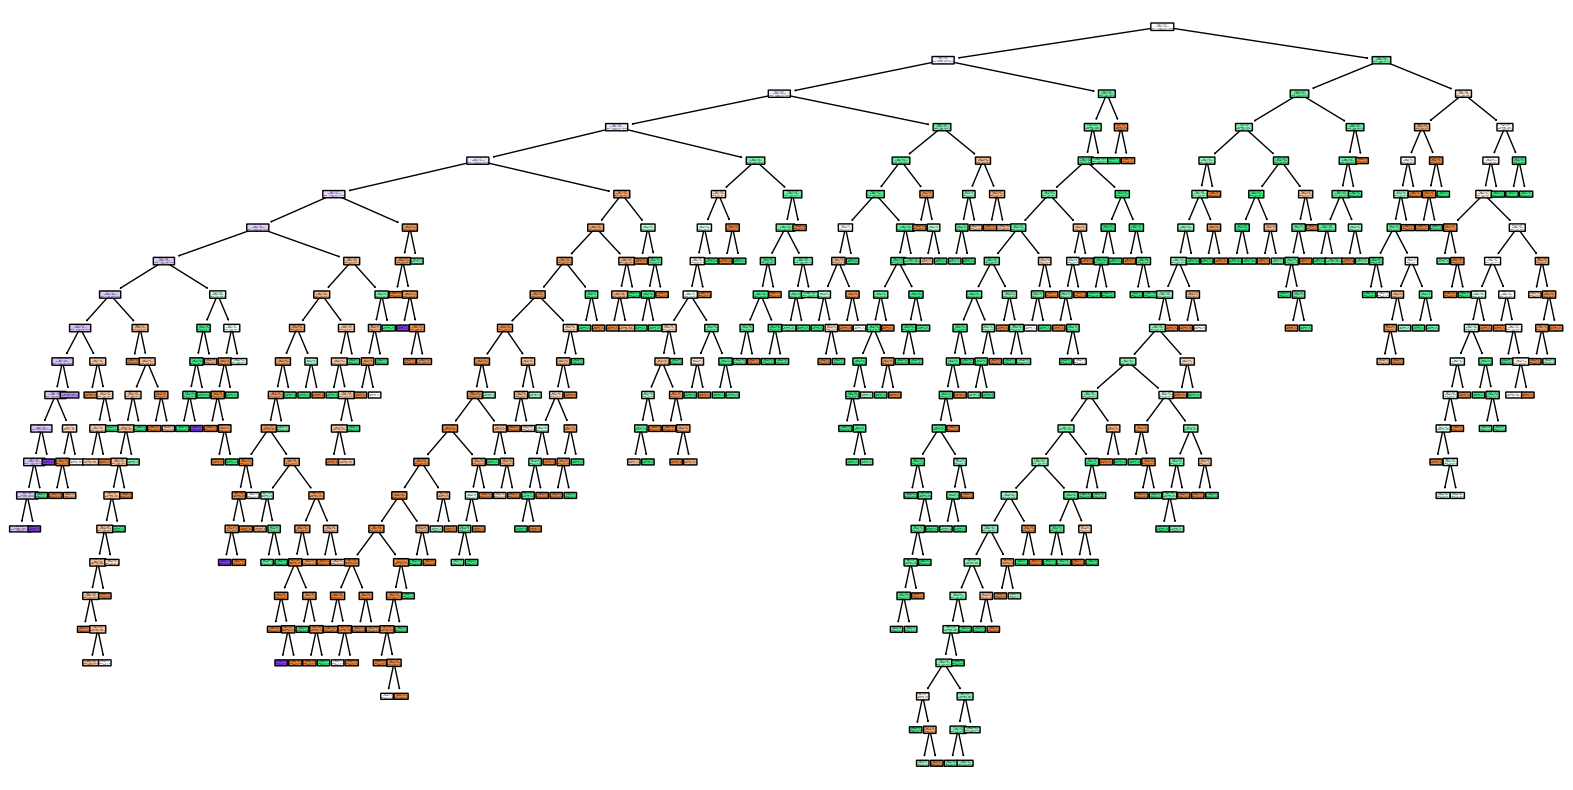

{'time_taken': 0.07052397727966309,
 'precision': 0.8397891513627708,
 'recall': 0.7425862416784346,
 'f1_score': 0.7637440561214637}

In [ ]:
# import time
# from sklearn.tree import DecisionTreeClassifier, plot_tree
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, f1_score

# # Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(tfidf_train_df, y_train)

# # Initialize Decision Tree with the best parameters
# dt_best = DecisionTreeClassifier(
#     criterion=best_params_dt['classifier__criterion'],
#     max_depth=best_params_dt['classifier__max_depth'],
#     min_samples_split=best_params_dt['classifier__min_samples_split'],
#     min_samples_leaf=best_params_dt['classifier__min_samples_leaf'],
#     random_state=42
# )

# # Time the fitting and prediction process
# start_time_dt = time.time()
# dt_best.fit(X_train_smote, y_train_smote)
# predictions_dt = dt_best.predict(tfidf_test_df)
# end_time_dt = time.time()
# time_taken_dt = end_time_dt - start_time_dt

# # Calculate precision, recall, and F1 score
# precision_dt = precision_score(y_test, predictions_dt, average='weighted')
# recall_dt = recall_score(y_test, predictions_dt, average='weighted')
# f1_dt = f1_score(y_test, predictions_dt, average='weighted')

# # Compile results for the Decision Tree classifier
# results_dt = {
#     'time_taken': time_taken_dt,
#     'precision': precision_dt,
#     'recall': recall_dt,
#     'f1_score': f1_dt
# }

# # Now, plot the Decision Tree using the feature names from TF-IDF Vectorizer
# plt.figure(figsize=(20, 10))
# plot_tree(dt_best, filled=True, feature_names=tfidf_vectorizer.get_feature_names_out(), class_names=np.unique(y_train).astype(str), rounded=True, proportion=False, precision=2)
# plt.show()

# # Display the results
# results_dt


#Model-2 And Model-3:Gaussian Naive Bayes & KNN

#Using only training set






In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from memory_profiler import memory_usage
import numpy as np
import time

# Initializing classifiers
lr = LogisticRegression(max_iter=1000)
svm = SVC()


precision_scorer = make_scorer(precision_score, average='weighted', zero_division=0)

# Modified evaluation function to fix the TypeError and handle the warnings
def evaluation(model, X, y, cv, scoring_metrics):
    start_time = time.time()
    # Note: Adjusted memory_usage call to not use indexing since it returns a float
    mem_usage = memory_usage((cross_validate, (model, X, y), {'cv': cv, 'scoring': scoring_metrics}), interval=0.1, max_usage=True)
    results = cross_validate(model, X, y, cv=cv, scoring=scoring_metrics, return_train_score=False)
    end_time = time.time()
    time_taken = end_time - start_time
    metrics_summary = {metric: np.mean(values) for metric, values in results.items() if 'test_' in metric}
    return metrics_summary, time_taken, mem_usage  # Directly return mem_usage

# Adjusting the scoring metrics to include the new precision_scorer
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': precision_scorer,
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}
# Evaluating Logistic Regression
results_lr, time_lr, mem_lr = evaluation(lr, X_train, y_train, cv=2, scoring_metrics=scoring_metrics)

# Evaluating SVM
results_svm, time_svm, mem_svm = evaluation(svm, X_train, y_train, cv=2, scoring_metrics=scoring_metrics)

print(f"Logistic Regression - Metrics: {results_lr}, Time: {time_lr} seconds, Memory: {mem_lr} MiB")
print(f"SVM - Metrics: {results_svm}, Time: {time_svm} seconds, Memory: {mem_svm} MiB")

Logistic Regression - Metrics: {'test_accuracy': 0.792948653283567, 'test_precision': 0.7340768962865598, 'test_recall': 0.792948653283567, 'test_f1': 0.7268188845833683}, Time: 0.5303781032562256 seconds, Memory: 470.1640625 MiB
SVM - Metrics: {'test_accuracy': 0.792898214465853, 'test_precision': 0.7339192713280231, 'test_recall': 0.792898214465853, 'test_f1': 0.7267833403437709}, Time: 8.64652943611145 seconds, Memory: 470.171875 MiB


#Hyperparameter Tuning

#Without using SMOTE and limiting the parameters to tune

In [ ]:

nb = GaussianNB()
knn = KNeighborsClassifier()


# Define hyperparameters to tune
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Define scoring metrics
score_metrics = {'accuracy': 'accuracy',
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted'),
                   'f1': make_scorer(f1_score, average='weighted')}

# Instantiate GridSearchCV for KNN
g_search = GridSearchCV(knn, param_grid, cv=5, scoring=score_metrics, refit='f1')

# Fit the GridSearchCV instance to the training data
g_search.fit(X_train, y_train)

# Get the best hyperparameters
ideal_para = g_search.best_params_

# Get the best mean F1-score
ideal_mean_f1 = g_search.best_score_

(ideal_para, ideal_mean_f1)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


({'n_neighbors': 3}, 0.7289817811246821)

#Using Smote

In [ ]:


# Custom transformer for converting sparse to dense (needed for GaussianNB with SMOTE)
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Create pipelines that first oversample with SMOTE and then apply the classifier
pipeline_nb = ImPipeline([
    ('smote', smote),  # SMOTE step for handling class imbalance
    ('to_dense', DenseTransformer()),  # Convert sparse matrix to dense, necessary for GaussianNB
    ('classifier', GaussianNB())  # The classifier
])

pipeline_knn = ImPipeline([
    ('smote', smote),  # SMOTE step for handling class imbalance
    # Note: For KNeighborsClassifier, converting to dense is not required
    ('classifier', KNeighborsClassifier())  # The classifier
])


# Define parameter grids: GaussianNB's parameter grid could be on var_smoothing, for KNN - n_neighbors, weights, and metric
param_grid_nb = {
    'classifier__var_smoothing': np.logspace(0, -9, num=10)
}
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Define multiple scoring metrics
scoring_metrics = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Setup GridSearchCV for each pipeline with multiple scoring metrics
grid_search_nb = GridSearchCV(pipeline_nb, param_grid_nb, scoring=scoring_metrics, refit='f1', cv=5, n_jobs=-1)
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, scoring=scoring_metrics, refit='f1', cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_nb.fit(X_train, y_train)
grid_search_knn.fit(X_train, y_train)

# Extract the best parameters and the best F1 score (since refit='f1')
best_params_nb = grid_search_nb.best_params_
best_f1_score_nb = grid_search_nb.best_score_
best_params_knn = grid_search_knn.best_params_
best_f1_score_knn = grid_search_knn.best_score_

# Display the best parameters and F1 scores for each classifier
(best_params_nb, best_f1_score_nb), (best_params_knn, best_f1_score_knn)


(({'classifier__var_smoothing': 0.001}, 0.7375511894300804),
 ({'classifier__metric': 'manhattan',
   'classifier__n_neighbors': 3,
   'classifier__weights': 'uniform'},
  0.7284335567989545))

#Using test set

In [ ]:

# Custom transformer for converting sparse to dense (needed for GaussianNB with SMOTE)
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

# Best parameters from the GridSearch output
best_params_nb = {'classifier__var_smoothing': 0.001}
best_params_knn = {
    'classifier__metric': 'manhattan',
    'classifier__n_neighbors': 3,
    'classifier__weights': 'uniform'
}

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Initialize GaussianNB and KNeighborsClassifier with best parameters
gnb = GaussianNB(var_smoothing=best_params_nb['classifier__var_smoothing'])
knn = KNeighborsClassifier(n_neighbors=best_params_knn['classifier__n_neighbors'],
                           weights=best_params_knn['classifier__weights'],
                           metric=best_params_knn['classifier__metric'])

# Create pipelines with SMOTE and the classifiers with best parameters
pipeline_nb = ImPipeline([
    ('smote', smote),
    ('to_dense', DenseTransformer()),
    ('classifier', gnb)
])

pipeline_knn = ImPipeline([
    ('smote', smote),
    ('classifier', knn)
])

# Time and score tracking for GaussianNB
start_time_nb = time.time()
pipeline_nb.fit(X_train, y_train)
predictions_nb = pipeline_nb.predict(X_test)
end_time_nb = time.time()
time_taken_nb = end_time_nb - start_time_nb

# Calculate scores for GaussianNB
scores_nb = {
    'accuracy': accuracy_score(y_test, predictions_nb),
    'precision': precision_score(y_test, predictions_nb, average='weighted'),
    'recall': recall_score(y_test, predictions_nb, average='weighted'),
    'f1_score': f1_score(y_test, predictions_nb, average='weighted')
}

# Time and score tracking for KNeighborsClassifier
start_time_knn = time.time()
pipeline_knn.fit(X_train, y_train)
predictions_knn = pipeline_knn.predict(X_test)
end_time_knn = time.time()
time_taken_knn = end_time_knn - start_time_knn

# Calculate scores for KNeighborsClassifier
scores_knn = {
    'accuracy': accuracy_score(y_test, predictions_knn),
    'precision': precision_score(y_test, predictions_knn, average='weighted'),
    'recall': recall_score(y_test, predictions_knn, average='weighted'),
    'f1_score': f1_score(y_test, predictions_knn, average='weighted')
}

# Compile results for each classifier into dictionaries
results_nb = {
    'time_taken': time_taken_nb,
    'scores': scores_nb
}

results_knn = {
    'time_taken': time_taken_knn,
    'scores': scores_knn
}

# Return the results
results_nb, results_knn



({'time_taken': 0.10944390296936035,
  'scores': {'accuracy': 0.7012305830139197,
   'precision': 0.8385631492090782,
   'recall': 0.7012305830139197,
   'f1_score': 0.7339717024624456}},
 {'time_taken': 14.754674196243286,
  'scores': {'accuracy': 0.6856969941496873,
   'precision': 0.8708823583190266,
   'recall': 0.6856969941496873,
   'f1_score': 0.7371002963104575}})

#Model 4:SVC

SVC with using just one set of parameters(may not be optimized)

In [ ]:
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline  # Use this Pipeline to ensure compatibility with imblearn's oversampler
from sklearn.metrics import classification_report


svm = SVC(C=1, gamma=0.01)


oversampler = RandomOverSampler(random_state=42)


pl_svm = Pipeline([('oversampler', oversampler), ('svm', svm)])


pl_svm.fit(X_train, y_train)


y_pred_svm = pl_svm.predict(X_test)


report_svm = classification_report(y_test, y_pred_svm, target_names=['Class 0', 'Class 1', 'Class 2'])

print(report_svm)



              precision    recall  f1-score   support

     Class 0       0.11      0.21      0.15       290
     Class 1       0.97      0.69      0.80      3832
     Class 2       0.48      0.98      0.64       835

    accuracy                           0.71      4957
   macro avg       0.52      0.63      0.53      4957
weighted avg       0.84      0.71      0.74      4957



#Hyperparamter Tuning

In [ ]:

# Define the parameter grid for SVC
param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [0.001, 0.01, 0.1, 1],
    'classifier__kernel': ['rbf', 'linear']
}

# Define multiple scoring metrics
scoring_metrics = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Create an SVC pipeline with SMOTE
pipeline_svc = ImPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(random_state=42))
])

# Setup GridSearchCV for SVC pipeline with multiple scoring metrics
grid_search_svc = GridSearchCV(
    pipeline_svc,
    param_grid_svc,
    scoring=scoring_metrics,
    refit='f1',
    cv=5,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search_svc.fit(X_train, y_train)

# Extract the best parameters
best_params_svc = grid_search_svc.best_params_


# Using best parameter

In [ ]:


# Initialize SVC with best parameters
svc_best = SVC(
    C=best_params_svc['classifier__C'],
    gamma=best_params_svc['classifier__gamma'],
    kernel=best_params_svc['classifier__kernel'],
    random_state=42
)

# Update pipeline with the best parameters
pipeline_svc_best = ImPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', svc_best)
])

# Time the fitting and prediction process
start_time_svc = time.time()
pipeline_svc_best.fit(X_train, y_train)
predictions_svc = pipeline_svc_best.predict(X_test)
end_time_svc = time.time()
time_taken_svc = end_time_svc - start_time_svc
memory = memory_usage(max_usage=True)

# Calculate precision, recall, and F1 score
accuracy_svc = accuracy_score(y_test, predictions_svc)
precision_svc = precision_score(y_test, predictions_svc, average='weighted')
recall_svc = recall_score(y_test, predictions_svc, average='weighted')
f1_svc = f1_score(y_test, predictions_svc, average='weighted')

# Results - Time and scores for SVC
results_svc = {
    'time_taken': time_taken_svc,
    'precision': precision_svc,
    'recall': recall_svc,
    'f1_score': f1_svc,
    'accuracy': accuracy_svc
}
print(results_svc)
print(f"Memory used: {memory} MiB")



{'time_taken': 40.11726784706116, 'precision': 0.8409865504171639, 'recall': 0.7357272543877346, 'f1_score': 0.75936182178692, 'accuracy': 0.7357272543877346}
Memory used: 490.55859375 MiB


# Model-5:Logistic Regression

#Hyperparamter Tuning

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline  # Ensure compatibility with imblearn's SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # 'liblinear' is a good choice for L1 penalty
}

# Define multiple scoring metrics
scoring_metrics = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Create a Logistic Regression pipeline with SMOTE
pipeline_lr = ImPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

# Setup GridSearchCV for Logistic Regression pipeline with multiple scoring metrics
grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    scoring=scoring_metrics,
    refit='f1',
    cv=5,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search_lr.fit(X_train, y_train)

# Extract the best parameters
best_params_lr = grid_search_lr.best_params_



# Logistic Regression Using optimized parameters


In [ ]:

# Initialize Logistic Regression with the best parameters
lr_best = LogisticRegression(
    C=best_params_lr['classifier__C'],
    penalty=best_params_lr['classifier__penalty'],
    solver=best_params_lr['classifier__solver'],
    max_iter=10000,
    random_state=42
)

# Update pipeline with the best parameters
pipeline_lr_best = ImPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', lr_best)
])

# Time the fitting and prediction process
start_time_lr = time.time()
pipeline_lr_best.fit(X_train, y_train)
predictions_lr = pipeline_lr_best.predict(X_test)
end_time_lr = time.time()
time_taken_lr = end_time_lr - start_time_lr
memory = memory_usage(max_usage=True)

# Calculate precision, recall, and F1 score
accuracy_lr = accuracy_score(y_test, predictions_lr)
precision_lr = precision_score(y_test, predictions_lr, average='weighted')
recall_lr = recall_score(y_test, predictions_lr, average='weighted')
f1_lr = f1_score(y_test, predictions_lr, average='weighted')

# Results - Time and scores for Logistic Regression
results_lr = {
    'time_taken': time_taken_lr,
    'precision': precision_lr,
    'recall': recall_lr,
    'f1_score': f1_lr,
    'accuracy': accuracy_lr
}
print(results_lr)
print(f"Memory used: {memory} MiB")


{'time_taken': 0.1322951316833496, 'precision': 0.8419037469989289, 'recall': 0.7506556384910228, 'f1_score': 0.7694301888846492, 'accuracy': 0.7506556384910228}
Memory used: 470.3828125 MiB
